# Formula 1

In [111]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


Run the below codeblock if you want to test logistic regression and/or neural network. 

For SVM's run the block below the next one. 

In [112]:
# Config for regression/NN
regress = True


Run the codeblock below if you want to test SVMs

In [100]:
# Config for SVMs
regress = False


# 1 Gather Data

In [113]:
# Set data directory path
data_dir_path = "../data/"

# Read relevant csv files
results = pd.read_csv(data_dir_path + "results.csv", na_values=np.nan)
driver_standings = pd.read_csv(data_dir_path + "driver_standings.csv", na_values=np.nan)
constructor_standings = pd.read_csv(
    data_dir_path + "constructor_standings.csv", na_values=np.nan
)
raceYears = pd.read_csv(data_dir_path + "races.csv", na_values=np.nan)
names = pd.read_csv(data_dir_path + "drivers.csv", na_values=np.nan)
circuits = pd.read_csv(data_dir_path + "circuits.csv", na_values=np.nan)

# Filter columns
raceYears = raceYears[["raceId", "year", "circuitId"]]
raceYears = raceYears[raceYears["year"] >= 2014]  # Only data after 2014
results = results[["raceId", "driverId", "constructorId", "grid", "position"]]
driver_standings = driver_standings[
    ["raceId", "driverId", "position", "wins", "points"]
]
constructor_standings = constructor_standings[
    ["raceId", "constructorId", "position", "wins", "points"]
]
names = names[["driverId", "driverRef"]]
circuits = circuits[["circuitId", "lat", "lng", "alt"]]

# Rename because other csvs also have position
driver_standings = driver_standings.rename(columns={"position": "driverStanding"})
constructor_standings = constructor_standings.rename(
    columns={
        "position": "constructorStanding",
        "wins": "constructorWins",
        "points": "constructorPoints",
    }
)

# Merge dataframes
race_circuit = pd.merge(raceYears, circuits, on=["circuitId"], how="inner")
year_driver_standing = pd.merge(
    race_circuit, driver_standings, on=["raceId"], how="inner"
)
results_driver_standings = pd.merge(
    results, year_driver_standing, on=["raceId", "driverId"], how="inner"
)
joined_data = pd.merge(
    results_driver_standings,
    constructor_standings,
    on=["raceId", "constructorId"],
    how="inner",
)
joined_data = pd.merge(joined_data, names, on=["driverId"], how="inner")

# Drop irrelevant columns
joined_data.drop(
    columns=["raceId", "constructorId", "driverId", "circuitId"], inplace=True
)

# Replace proprietary null values with last palce (20 after 2014)
joined_data.replace(to_replace="\\N", value=20, inplace=True)
joined_data["position"] = joined_data["position"].astype(int)

# Drop year column
joined_data.drop("year", axis=1, inplace=True)

# Set feature and target variables
X = joined_data[
    [
        "grid",
        "driverStanding",
        "constructorStanding",
        "wins",
        "points",
        "lat",
        "lng",
        "alt",
        "constructorPoints",
        "constructorWins",
    ]
]
Y = joined_data[["position"]]


# Divide by train data and test data
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, shuffle=True
)

In [114]:
def edit_Y(y, regression=True):
    """Edits Y to be 1 or not 1 for regression or not regression.

    Notes:
        Pandas DF is passed by reference, so no returns.

    Args:
        y (pd.DataFrame): Dataframe with column position
        regression (bool, optional): True if regression, false for others.
    """
    y.loc[(y["position"] != 1) & (y["position"] != 2) & (y["position"] != 3)] = (
        0 if regression else -1
    )
    # For binary - podium vs not podium
    # y.loc[(y["position"] == 2) | (y["position"] == 3)] = 1

# 2 Standardise and Scale

In [115]:
# Convert features to numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# Transform position for regression/NN or SVM
edit_Y(Y_train, regression=regress)
edit_Y(Y_test, regression=regress)

# Convert results to numpy arrays
Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()

# Reshape to 1D array
Y_train = Y_train.reshape(Y_train.shape[0])
Y_test = Y_test.reshape(Y_test.shape[0])

# Scale data
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# 3 Plotting Functions

In [116]:
def plot(
    training_error, testing_error, training_acc, testing_acc, xaxis, xlabel, title=""
):
    """Plots training and testing error and accuracy.

    Args:
        training_error (list): Training error
        testing_error (list): Testing error
        training_acc (list): Training accuracy
        testing_acc (list): Testing accuracy
        xaxis (list): X axis labels
        xlabel (str): X axis label
        title (str, optional): Title of plot. Defaults to "".

    Returns:
        None. Plots graph.
    """
    # Figure size and title
    plt.figure(figsize=(15, 6), dpi=80)
    plt.suptitle(title, fontsize=16)

    # Plot training and testing error in first subplot
    plt.subplot(1, 2, 1)
    plt.plot(training_error, label="Training Error")
    plt.plot(testing_error, label="Testing Error")
    plt.xticks(np.arange(len(xaxis)), xaxis)
    plt.xlabel(xlabel)
    plt.ylabel("Error")
    plt.legend()

    # Plot training and testing accuracy in second subplot
    plt.subplot(1, 2, 2)
    plt.plot(training_acc, label="Training Accuracy")
    plt.plot(testing_acc, label="Testing Accuracy")
    plt.xticks(np.arange(len(xaxis)), xaxis)
    plt.xlabel(xlabel)
    plt.ylabel("Accuracy")
    plt.legend()

    # Show plot
    plt.show()

# 4A Logistic Regression

In [117]:
def polynomial_logistic_regression(X_train, Y_train, X_test, Y_test, max_degree=6):
    """Polynomial logistic regression

    Args:
        X_train (np.array): Training data
        Y_train (np.array): Training labels
        X_test (np.array): Testing data
        Y_test (np.array): Testing labels
        max_degree (int, optional): Max degree of polynomial. Defaults to 6.
    """
    # Init logistic regression
    _lambda = 0.7
    logreg = LogisticRegression(
        multi_class="multinomial", max_iter=100_000, penalty="l2", C=1 / _lambda
    )

    # Init lists for errors and accuracies
    training_error, testing_error = [], []
    training_acc, testing_acc = [], []

    # Loop through degrees
    print("Polynomial Logistic Regression Score")
    print("Degree \t Test Score \t Train Score")
    for i in range(1, max_degree + 1):
        # Init polynomial features
        poly = PolynomialFeatures(degree=i)

        # Polynomial fit of training data
        X_train_poly = poly.fit_transform(X_train)

        # Train model
        logreg.fit(X_train_poly, Y_train)

        # Polynomial fit of test data
        X_test_poly = poly.fit_transform(X_test)

        # Get scores
        training_score = logreg.score(X_train_poly, Y_train)
        testing_score = logreg.score(X_test_poly, Y_test)

        # Append accuracy
        training_acc.append(training_score)
        testing_acc.append(testing_score)

        # Append errors
        training_error.append(1 - training_score)
        testing_error.append(1 - testing_score)

        # Fancy print B)
        print(f"{i} \t {testing_score*100.0:.2f}% \t {training_score*100.0:.2f}%")

    return training_error, testing_error, training_acc, testing_acc

In [ ]:
max_degree = 7
(
    training_error,
    testing_error,
    training_acc,
    testing_acc,
) = polynomial_logistic_regression(
    X_train, Y_train, X_test, Y_test, max_degree=max_degree
)

plot(
    training_error,
    testing_error,
    training_acc,
    testing_acc,
    range(1, max_degree + 1),
    "Degree",
    title="Polynomial Logistic Regression",
)

# 4B SVM

In [106]:
def rbf_svm(X_train, Y_train, X_test, Y_test, costs, gamma=0.1):
    """RBF SVM

    Args:
        X_train (np.array): Training data
        Y_train (np.array): Training labels
        X_test (np.array): Testing data
        Y_test (np.array): Testing labels
        costs (list): The costs to test
        gamma (float, optional): Gamma value. Defaults to 0.1.

    Returns:
        training_error (list): Training errors for each cost
        testing_error (list): Testing errors for each cost
        training_acc (list): Training accuracies for each cost
        testing_acc (list): Testing accuracies for each cost
    """
    training_error, testing_error = [], []
    training_acc, testing_acc = [], []

    print("RBF SVM Score")
    print("C \t Test Score \t Train Score")

    for c in costs:
        svmachine = SVC(kernel="rbf", C=c, gamma=gamma)
        svmachine.fit(X_train, Y_train)

        # Get scores
        training_score = svmachine.score(X_train, Y_train)
        testing_score = svmachine.score(X_test, Y_test)

        # Append accuracy
        training_acc.append(training_score)
        testing_acc.append(testing_score)

        # Append errors
        training_error.append(1 - training_score)
        testing_error.append(1 - testing_score)

        # Fancy print B)
        print(f"{c} \t {testing_score*100.0:.2f}% \t {training_score*100.0:.2f}%")

    return training_error, testing_error, training_acc, testing_acc


def polynomial_svm(X_train, Y_train, X_test, Y_test, max_degree=6, c=0.1):
    """Polynomial Support Vector Machine

    Args:
        X_train (np.array): Training data
        Y_train (np.array): Training labels
        X_test (np.array): Testing data
        Y_test (np.array): Testing labels
        max_degree (int, optional): The maximum degree to test. Defaults to 6.

    Returns:
        training_error (list): Training errors for each degree
        testing_error (list): Testing errors for each degree
        training_acc (list): Training accuracies for each degree
        testing_acc (list): Testing accuracies for each degree
    """
    training_error, testing_error = [], []
    training_acc, testing_acc = [], []

    print("Polynomial SVM Score")
    print("Degree \t Test Score \t Train Score")
    for i in range(1, max_degree + 1):
        svmachine = SVC(kernel="poly", degree=i, C=c)
        svmachine.fit(X_train, Y_train)

        # Get scores
        training_score = svmachine.score(X_train, Y_train)
        testing_score = svmachine.score(X_test, Y_test)

        # Append accuracy
        training_acc.append(training_score)
        testing_acc.append(testing_score)

        # Append errors
        training_error.append(1 - training_score)
        testing_error.append(1 - testing_score)

        # Fancy print B)
        print(f"{i} \t {testing_score*100.0:.2f}% \t {training_score*100.0:.2f}%")

    return training_error, testing_error, training_acc, testing_acc


Polynomial SVM Score
Degree 	 Test Score 	 Train Score
1 	 88.41% 	 86.51%
2 	 88.54% 	 86.34%
3 	 88.68% 	 87.62%
4 	 88.01% 	 88.30%
5 	 87.20% 	 89.34%
6 	 87.06% 	 89.78%
7 	 86.79% 	 90.62%
8 	 86.79% 	 90.93%
9 	 87.20% 	 91.57%
10 	 87.33% 	 91.80%
11 	 86.79% 	 92.24%
12 	 86.79% 	 92.41%
13 	 86.93% 	 92.78%
14 	 86.52% 	 92.88%
15 	 86.39% 	 92.85%
16 	 86.12% 	 92.95%
17 	 85.85% 	 92.92%
18 	 85.71% 	 93.05%
19 	 85.58% 	 92.92%
20 	 85.31% 	 93.02%


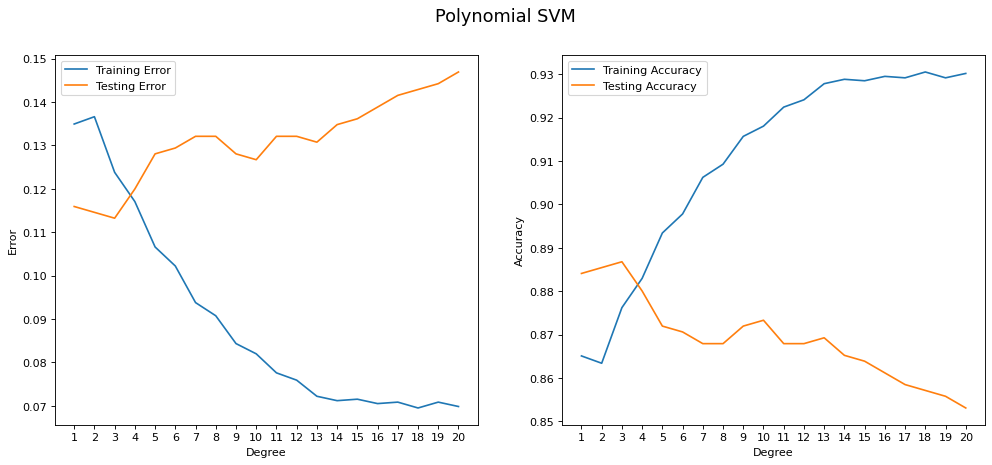

In [107]:
# Set overkill max degree
max_degree = 20

# Get polynomial logistic regression
training_error, testing_error, training_acc, testing_acc = polynomial_svm(
    X_train, Y_train, X_test, Y_test, max_degree=max_degree
)

# Plot
plot(
    training_error,
    testing_error,
    training_acc,
    testing_acc,
    range(1, max_degree + 1),
    "Degree",
    title="Polynomial SVM",
)

Polynomial SVM with different costs
Cost: 0.0001
Polynomial SVM Score
Degree 	 Test Score 	 Train Score
1 	 86.39% 	 84.99%
2 	 86.39% 	 84.99%
3 	 86.79% 	 85.40%
4 	 87.20% 	 85.70%
5 	 87.47% 	 85.94%
6 	 88.27% 	 86.61%
7 	 87.87% 	 87.22%
8 	 87.47% 	 87.55%
9 	 86.39% 	 88.13%
10 	 86.25% 	 88.47%


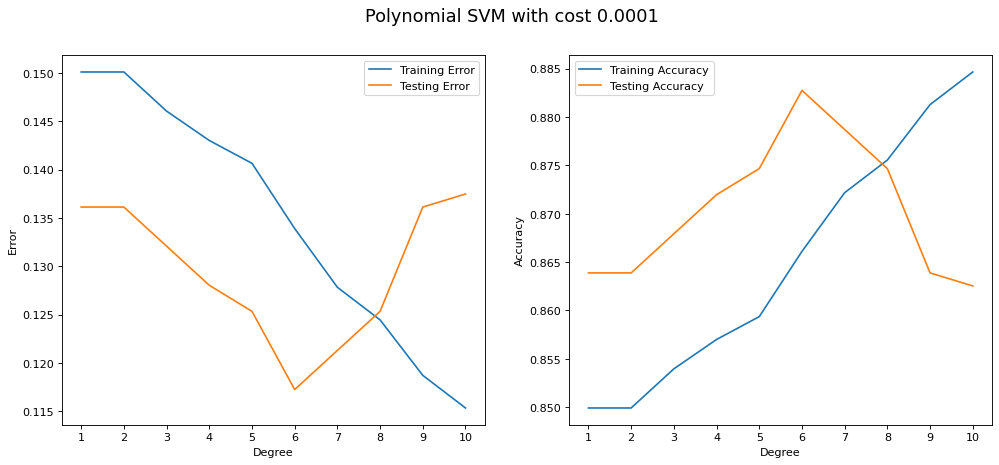

Cost: 0.001
Polynomial SVM Score
Degree 	 Test Score 	 Train Score
1 	 86.39% 	 84.99%
2 	 87.06% 	 85.50%
3 	 87.47% 	 85.94%
4 	 87.87% 	 86.14%
5 	 88.27% 	 86.68%
6 	 88.14% 	 87.32%
7 	 87.60% 	 87.82%
8 	 87.06% 	 88.26%
9 	 86.66% 	 88.84%
10 	 86.93% 	 89.54%


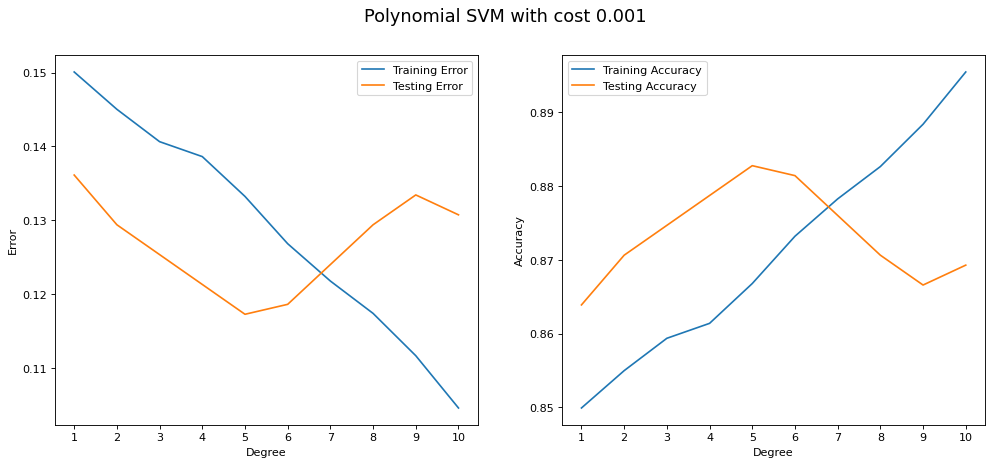

Cost: 0.01
Polynomial SVM Score
Degree 	 Test Score 	 Train Score
1 	 87.20% 	 85.53%
2 	 88.14% 	 86.14%
3 	 88.27% 	 86.48%
4 	 88.27% 	 86.75%
5 	 87.60% 	 87.49%
6 	 87.20% 	 88.36%
7 	 86.79% 	 89.14%
8 	 86.93% 	 89.51%
9 	 86.66% 	 90.32%
10 	 86.66% 	 90.59%


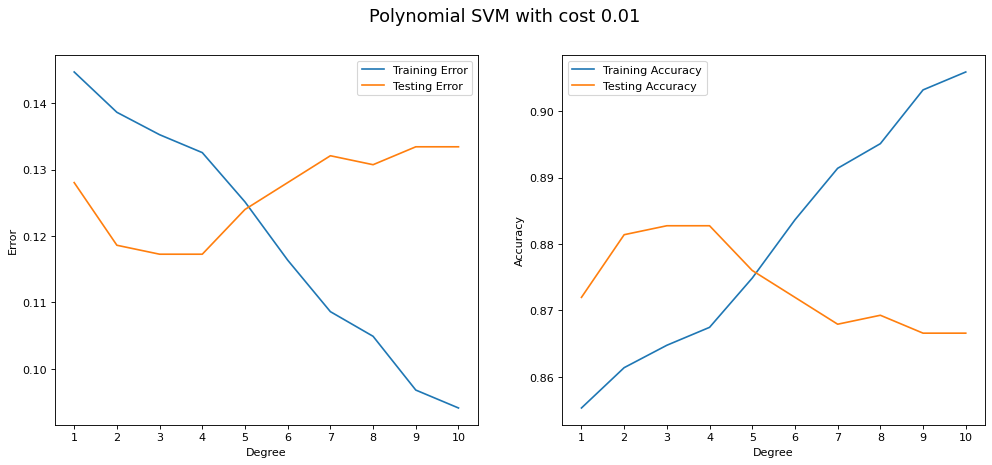

Cost: 0.1
Polynomial SVM Score
Degree 	 Test Score 	 Train Score
1 	 88.41% 	 86.51%
2 	 88.54% 	 86.34%
3 	 88.68% 	 87.62%
4 	 88.01% 	 88.30%
5 	 87.20% 	 89.34%
6 	 87.06% 	 89.78%
7 	 86.79% 	 90.62%
8 	 86.79% 	 90.93%
9 	 87.20% 	 91.57%
10 	 87.33% 	 91.80%


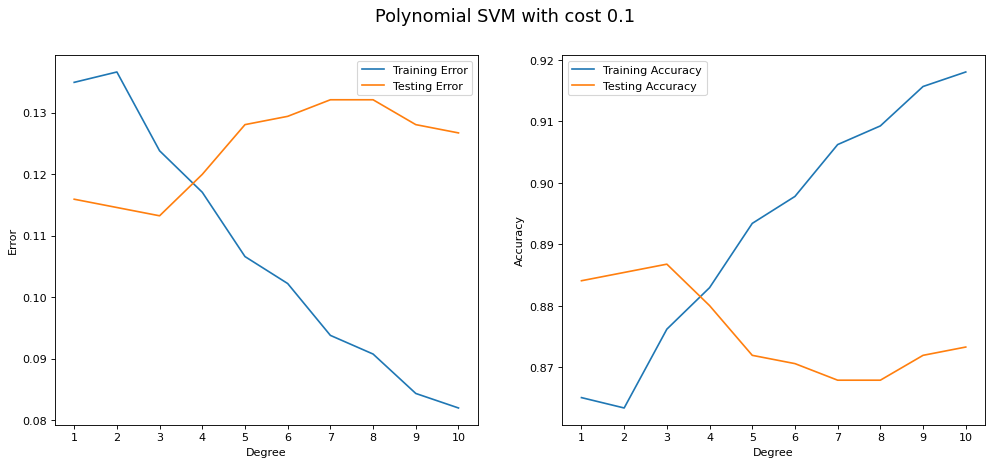

Cost: 1
Polynomial SVM Score
Degree 	 Test Score 	 Train Score
1 	 88.95% 	 87.28%
2 	 88.68% 	 87.25%
3 	 88.27% 	 89.61%
4 	 87.74% 	 89.98%
5 	 87.20% 	 91.13%
6 	 86.93% 	 91.74%
7 	 87.06% 	 92.82%
8 	 86.52% 	 93.12%
9 	 86.39% 	 93.56%
10 	 86.12% 	 93.59%


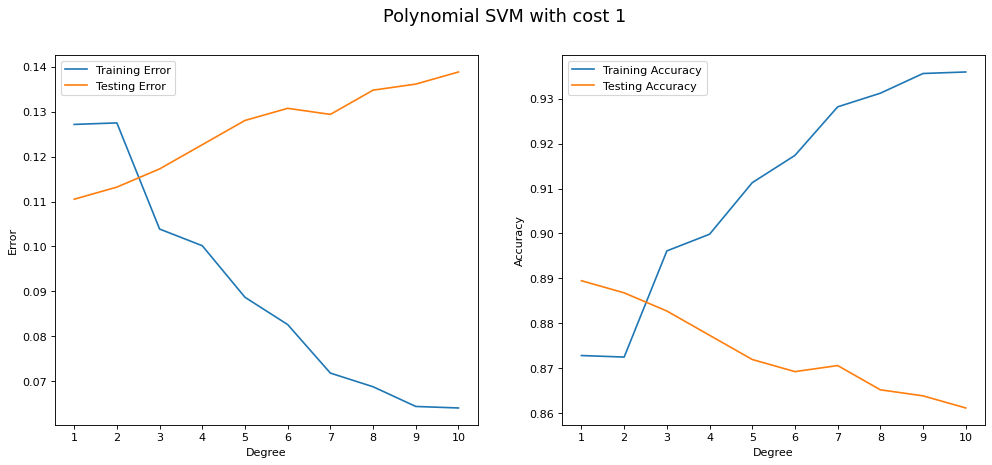

Cost: 10.0
Polynomial SVM Score
Degree 	 Test Score 	 Train Score
1 	 88.81% 	 88.09%
2 	 89.35% 	 88.33%
3 	 88.14% 	 90.86%
4 	 87.20% 	 91.74%
5 	 86.12% 	 93.42%
6 	 85.98% 	 93.96%
7 	 86.25% 	 94.47%
8 	 87.06% 	 94.64%
9 	 87.47% 	 94.74%
10 	 87.47% 	 94.74%


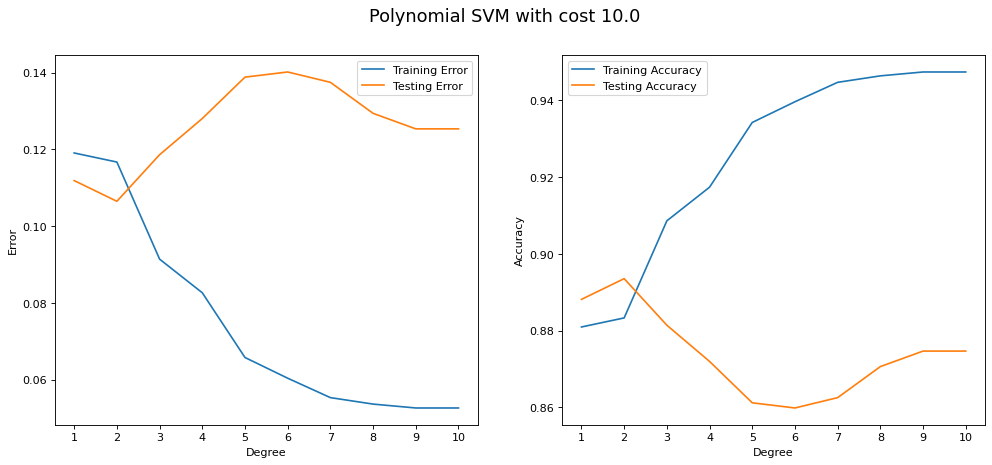

Cost: 100.0
Polynomial SVM Score
Degree 	 Test Score 	 Train Score
1 	 88.81% 	 88.33%
2 	 89.08% 	 88.80%
3 	 87.33% 	 92.68%
4 	 87.06% 	 94.33%
5 	 86.12% 	 95.28%
6 	 86.39% 	 95.89%
7 	 86.66% 	 96.12%
8 	 86.79% 	 96.19%
9 	 86.12% 	 96.19%
10 	 86.12% 	 96.05%


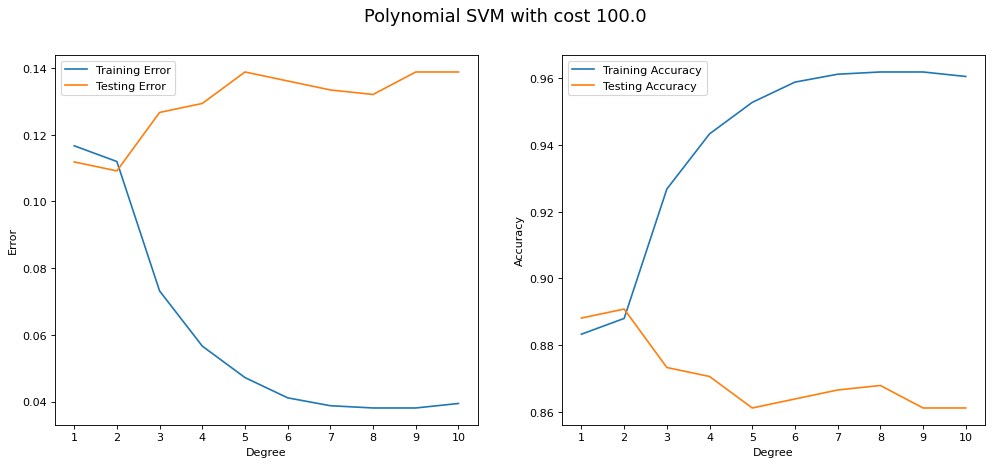

Cost: 1000.0
Polynomial SVM Score
Degree 	 Test Score 	 Train Score
1 	 89.08% 	 88.26%
2 	 89.22% 	 88.97%
3 	 86.12% 	 94.44%
4 	 85.18% 	 96.73%
5 	 85.18% 	 97.34%
6 	 84.91% 	 97.74%
7 	 86.25% 	 97.84%
8 	 85.98% 	 97.71%
9 	 86.52% 	 97.47%
10 	 85.58% 	 97.37%


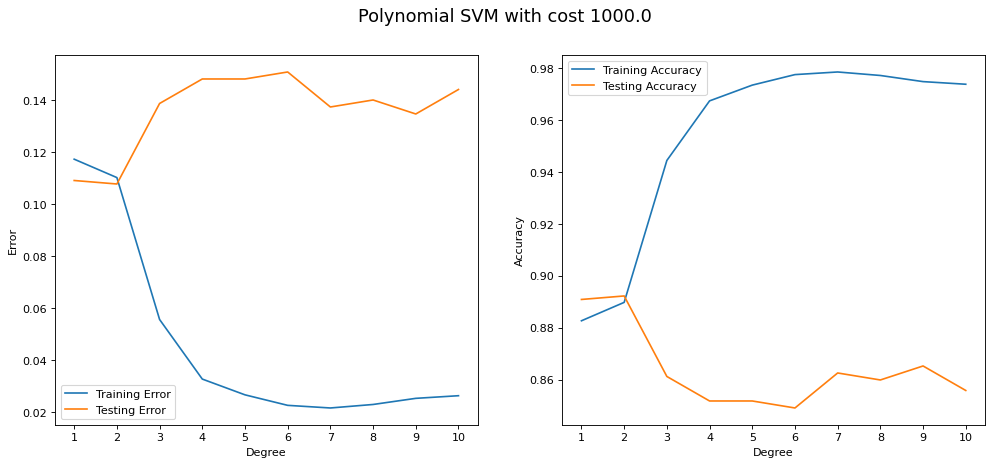

In [108]:
# Set costs and max degree
costs = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
max_degree = 10

print("\033[1m", "Polynomial SVM with different costs", "\033[0m", sep="")
for c in costs:
    print("\033[1m", f"Cost: {c}", "\033[0m", sep="")
    # Get polynomial logistic regression
    training_error, testing_error, training_acc, testing_acc = polynomial_svm(
        X_train, Y_train, X_test, Y_test, max_degree=max_degree, c=c
    )

    plot(
        training_error,
        testing_error,
        training_acc,
        testing_acc,
        range(1, max_degree + 1),
        "Degree",
        title=f"Polynomial SVM with cost {c}",
    )

Polynomial SVM with different Gammas
Gamma: 1e-06
RBF SVM Score
C 	 Test Score 	 Train Score
0.0001 	 86.39% 	 84.99%
0.001 	 86.39% 	 84.99%
0.01 	 86.39% 	 84.99%
0.1 	 86.39% 	 84.99%
1 	 86.39% 	 84.99%
10.0 	 86.39% 	 84.99%
100.0 	 86.39% 	 84.99%
1000.0 	 88.14% 	 86.07%


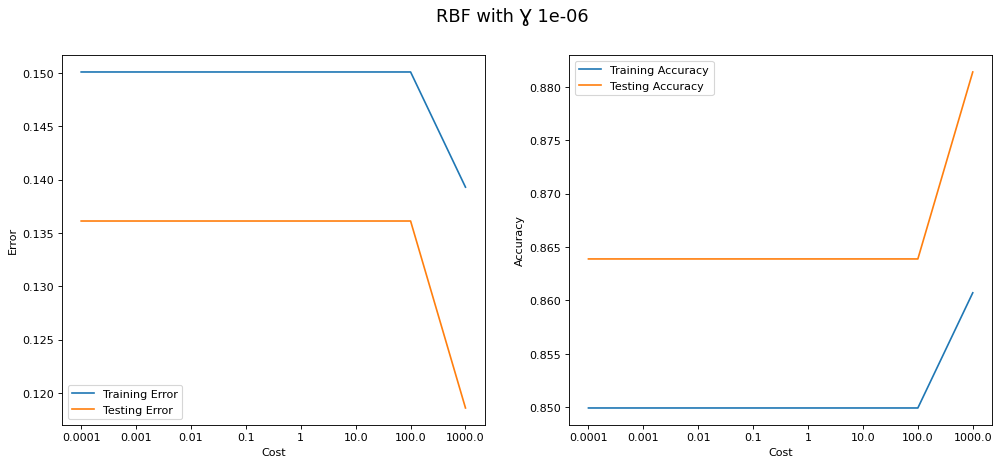

Gamma: 1e-05
RBF SVM Score
C 	 Test Score 	 Train Score
0.0001 	 86.39% 	 84.99%
0.001 	 86.39% 	 84.99%
0.01 	 86.39% 	 84.99%
0.1 	 86.39% 	 84.99%
1 	 86.39% 	 84.99%
10.0 	 86.39% 	 84.99%
100.0 	 88.14% 	 86.07%
1000.0 	 88.54% 	 86.81%


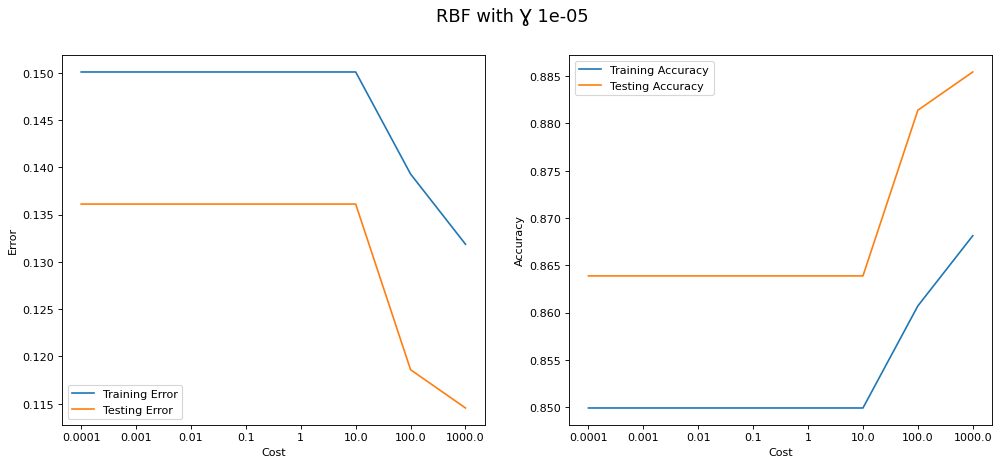

Gamma: 0.0001
RBF SVM Score
C 	 Test Score 	 Train Score
0.0001 	 86.39% 	 84.99%
0.001 	 86.39% 	 84.99%
0.01 	 86.39% 	 84.99%
0.1 	 86.39% 	 84.99%
1 	 86.39% 	 84.99%
10.0 	 88.14% 	 86.10%
100.0 	 88.54% 	 86.81%
1000.0 	 89.08% 	 87.35%


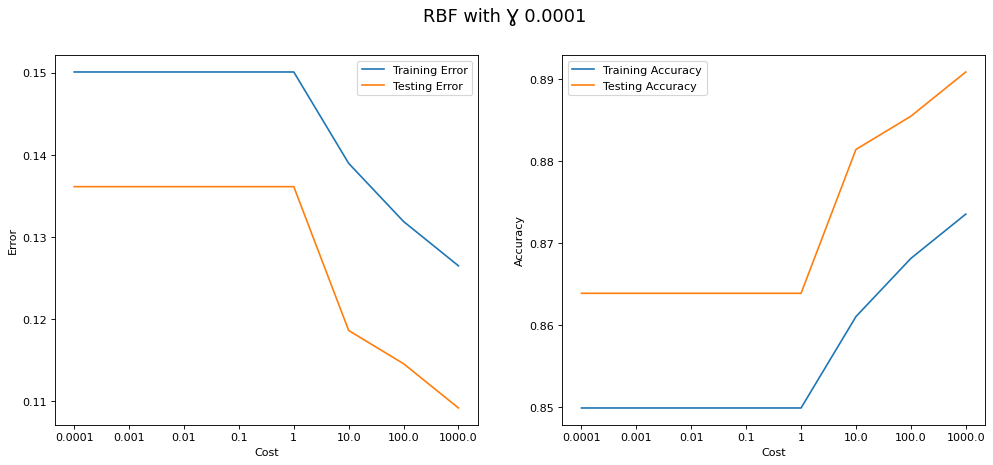

Gamma: 0.001
RBF SVM Score
C 	 Test Score 	 Train Score
0.0001 	 86.39% 	 84.99%
0.001 	 86.39% 	 84.99%
0.01 	 86.39% 	 84.99%
0.1 	 86.39% 	 84.99%
1 	 88.14% 	 86.10%
10.0 	 88.41% 	 86.75%
100.0 	 88.54% 	 87.05%
1000.0 	 89.22% 	 88.13%


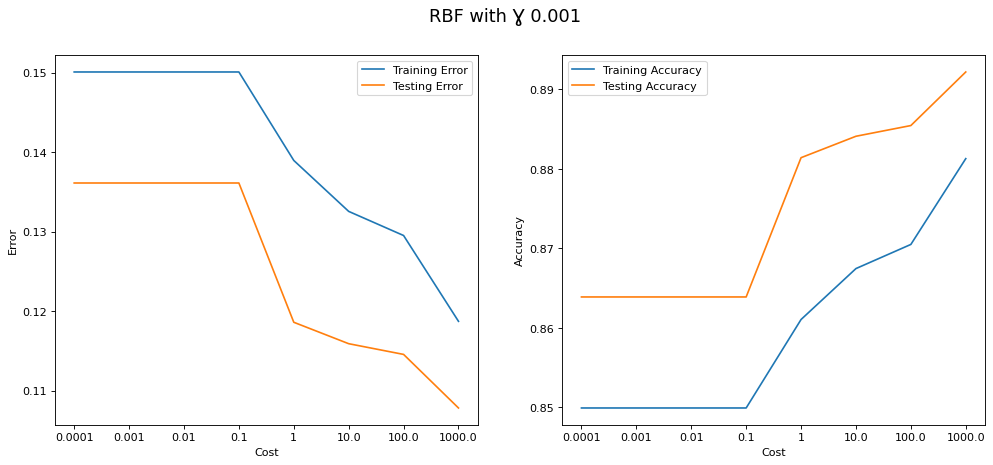

Gamma: 0.01
RBF SVM Score
C 	 Test Score 	 Train Score
0.0001 	 86.39% 	 84.99%
0.001 	 86.39% 	 84.99%
0.01 	 86.39% 	 84.99%
0.1 	 87.74% 	 86.07%
1 	 88.27% 	 86.75%
10.0 	 88.41% 	 87.39%
100.0 	 88.81% 	 88.74%
1000.0 	 88.14% 	 90.22%


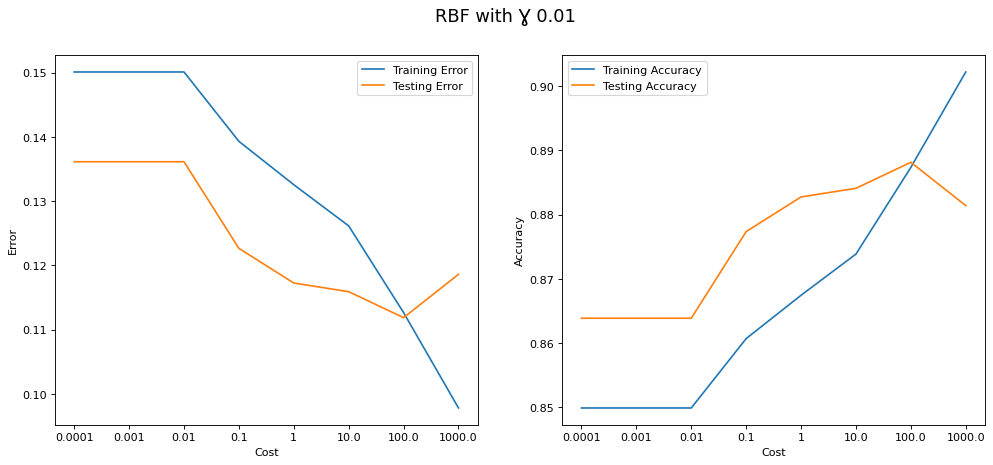

In [109]:
# Set costs and max degree
costs = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
gammas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]

print("\033[1m", "Polynomial SVM with different Gammas", "\033[0m", sep="")
for gam in gammas:
    print("\033[1m", f"Gamma: {gam}", "\033[0m", sep="")
    # Get polynomial logistic regression
    training_error, testing_error, training_acc, testing_acc = rbf_svm(
        X_train, Y_train, X_test, Y_test, costs=costs, gamma=gam
    )

    plot(
        training_error,
        testing_error,
        training_acc,
        testing_acc,
        costs,
        "Cost",
        title=f"RBF with Ɣ {gam}",
    )


RBF SVM Score
C 	 Test Score 	 Train Score
0.0001 	 86.39% 	 84.99%
0.001 	 86.39% 	 84.99%
0.01 	 86.39% 	 84.99%
0.1 	 88.54% 	 86.37%
1 	 88.41% 	 87.96%
10.0 	 87.33% 	 90.69%
100.0 	 86.25% 	 93.79%
1000.0 	 85.58% 	 97.27%


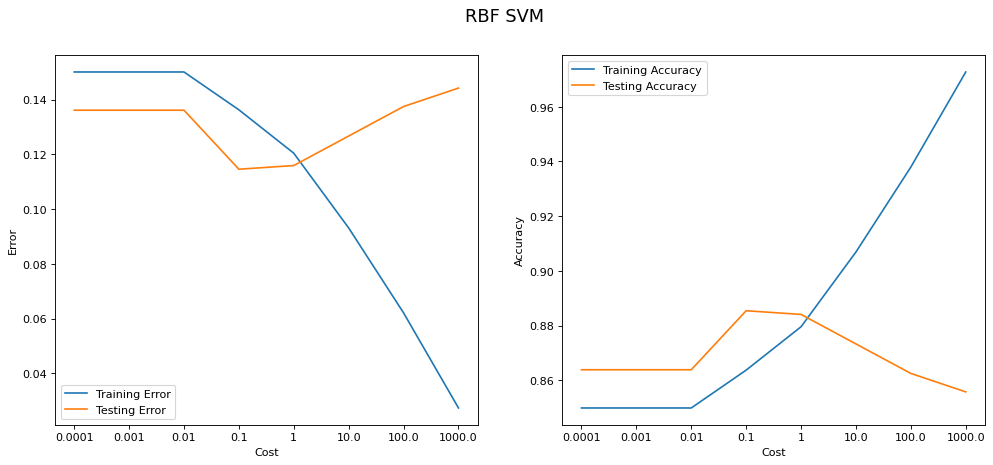

In [110]:
# Set costs
costs = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]

# Get polynomial logistic regression
training_error, testing_error, training_acc, testing_acc = rbf_svm(
    X_train, Y_train, X_test, Y_test, costs
)

# Plot
plot(
    training_error,
    testing_error,
    training_acc,
    testing_acc,
    costs,
    "Cost",
    title="RBF SVM",
)

# 4C Neural Network

In [127]:
def nn_model(X_train, Y_train, X_test, Y_test):
    """Neural Network Model

    Args:
        X_train (np.array): Training data
        Y_train (np.array): Training labels
        X_test (np.array): Testing data
        Y_test (np.array): Testing labels

    Returns:

    """
    # Define the model architecture
    model = Sequential(
        [
            Dense(8, activation="softmax", input_shape=(10,)),
            Dense(4, activation="softmax"),
        ]
    )

    # Compile the model with an optimizer, loss function, and metrics
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    Y_train_one_hot = tf.one_hot(Y_train - 1, depth=4)
    Y_test_one_hot = tf.one_hot(Y_test - 1, depth=4)

    # Train the model on the training data
    model.fit(
        X_train,
        Y_train_one_hot,
        epochs=100,
        batch_size=32,
        validation_data=(X_test, Y_test_one_hot),
    )

    # Evaluate the model on the test data
    loss, accuracy = model.evaluate(X_test, Y_test_one_hot)

    print(f"Test loss: {loss*100:.2f}% \t Test accuracy: {accuracy*100:.2f}%")

In [128]:
nn_model(X_train, Y_train, X_test, Y_test)

Epoch 1/100
93/93 [==============================] - 1s 2ms/step - loss: 0.2003 - accuracy: 0.0874 - val_loss: 0.1827 - val_accuracy: 0.1038
Epoch 2/100
93/93 [==============================] - 0s 1ms/step - loss: 0.1988 - accuracy: 0.1589 - val_loss: 0.1814 - val_accuracy: 0.1914
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 0.1974 - accuracy: 0.2435 - val_loss: 0.1798 - val_accuracy: 0.2682
Epoch 4/100
93/93 [==============================] - 0s 1ms/step - loss: 0.1961 - accuracy: 0.2927 - val_loss: 0.1784 - val_accuracy: 0.3154
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 0.1948 - accuracy: 0.3086 - val_loss: 0.1770 - val_accuracy: 0.3261
Epoch 6/100
93/93 [==============================] - 0s 1ms/step - loss: 0.1938 - accuracy: 0.3025 - val_loss: 0.1762 - val_accuracy: 0.3221
Epoch 7/100
93/93 [==============================] - 0s 1ms/step - loss: 0.1931 - accuracy: 0.2951 - val_loss: 0.1751 - val_accuracy: 0.2925
Epoch 8/100
9